## Modelado de Temas : LSI / LDA

In [1]:
import pandas as pd 
import numpy as np 
import re
import nltk
from nltk.corpus import stopwords 

### 1. Cargar el archivo
Genera un DataFrame de Pandas llamado “df” y que contiene una única columna llamada “noticia” con 5658 renglones formados por los cuerpos de las noticias.

In [2]:
dfn = pd.read_json('noticiasTopicModeling.txt', lines=False, encoding='utf-8')

df = dfn[['texto']].copy()
df.rename(columns={'texto':'noticia'}, inplace=True)

In [3]:
print(df.shape)
df.head()

(5658, 1)


,noticia
0,"""España ha dejado de ser católica"", decía Manu..."
1,El clima de crispación social en Ceuta ha lleg...
2,El Gobierno ha alegado la suspensión de plazos...
3,"Puedes mandar tu pregunta, sugerencia o queja ..."
4,Panamá debe entregar esta semana a la Corte In...


### 2. Proceso de Limpieza 

In [4]:
# stopwords en español
stops = stopwords.words('spanish')

def clean_tok(doc):
  # Elimina los signos de puntuación, caracteres especiales y números
  tokens = re.sub(r'[^A-Za-záéíóúüñ\s]', ' ', doc).strip()

  # Elimina espacios en blanco adicionales y convierte a minúsculas
  tokens = ' '.join(re.findall(r'\b\w+\b', tokens.lower()))
  
  # Tokeniza por palabras, elimina stopwords y palabras de longitud menor a 2
  tokens = [w for w in tokens.split() if w not in stops and len(w) > 2]

  return tokens

In [5]:
clean_doc = [clean_tok(str(x)) for x in df['noticia']]

In [6]:
for x in clean_doc[0:3]:
  print(x)

['españa', 'dejado', 'ser', 'católica', 'decía', 'manuel', 'azaña', 'comienzo', 'segunda', 'república', 'aquel', 'congreso', 'diputados', 'aprobó', 'leyes', 'laicistas', 'metáfora', 'dejó', 'ser', 'católica', 'papel', 'ley', 'creencias', 'buena', 'parte', 'pueblo', 'migración', 'integración', 'europea', 'programa', 'vox', 'europa', 'saber', 'españa', 'domingo', 'noviembre', 'dejado', 'ser', 'excepción', 'europa', 'potencia', 'extrema', 'derecha', 'parlamento', 'metáfora', 'pues', 'precisamente', 'excepcional', 'tener', 'dictadura', 'mediados', 'setenta', 'dictador', 'aún', 'mausoleo', 'después', 'años', 'muerto', 'existía', 'tal', 'cosa', 'portugal', 'grecia', 'italia', 'alemania', 'países', 'dictaduras', 'fascistas', 'españa', 'pasó', 'portugal', 'italia', 'alemania', 'derrotó', 'fascismo', 'franquismo', 'murió', 'cama', 'harakiri', 'cortes', 'franquistas', 'ruptura', 'régimen', 'sino', 'reforma', 'nació', 'nuevo', 'país', 'sino', 'país', 'mutó', 'ley', 'ley', 'aun', 'así', 'españa', 

### 3. ¿Por qué en este caso no requerimos hacer una partición en entrenamiento, validación y prueba?

En esta actividad no se va a entrenar un modelo de clasificación, sino que se va a realizar un análisis para extraer el tema o temas de un texto. Dicho análisis se realiza con modelos no supervisados, por lo que no se requiere de una partición en entrenamiento, validación y prueba.

## Parte 1: Indexación semántica latente (LSI)

### 4. Matriz Tf-Idf
Encontrar la matriz Tf-idf de la columna de noticias. Despliega los primeros 5 renglones con algunas de sus columnas con sus nombres, donde las columnas son los tokens.

In [7]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer 

In [8]:
# Construimos vocabulario de palabras con base al conteo de tokens
midiccionario = Counter()

for k in range(len(clean_doc)):
  midiccionario.update(clean_doc[k])

In [9]:
print('Longitud del diccionario:', len(midiccionario))  
print(midiccionario.most_common(10)) 

Longitud del diccionario: 100089
[('gobierno', 10326), ('años', 7545), ('dos', 7400), ('personas', 7068), ('coronavirus', 6787), ('ser', 6652), ('madrid', 6173), ('según', 6050), ('españa', 6014), ('parte', 5957)]


In [10]:
# Convertimos cada renglón en un solo string

clean_doc = [' '.join(x) for x in clean_doc] 

# Observamos los primeros 3 renglones
for k in range(3):
  print(clean_doc[k])

españa dejado ser católica decía manuel azaña comienzo segunda república aquel congreso diputados aprobó leyes laicistas metáfora dejó ser católica papel ley creencias buena parte pueblo migración integración europea programa vox europa saber españa domingo noviembre dejado ser excepción europa potencia extrema derecha parlamento metáfora pues precisamente excepcional tener dictadura mediados setenta dictador aún mausoleo después años muerto existía tal cosa portugal grecia italia alemania países dictaduras fascistas españa pasó portugal italia alemania derrotó fascismo franquismo murió cama harakiri cortes franquistas ruptura régimen sino reforma nació nuevo país sino país mutó ley ley aun así españa parecía vacunada años franquismo sido bastantes llegado irrupción posfranquismo tras ser actores fundamentales gobiernos autonómicos locales ciudadanos españa dejado ser excepción aunque alianza popular manuel fraga bebiera franquismo sociológico fuerza nueva blas piñar búnker franquista 

In [11]:
# Obtenemos nuestro vocabulario de tokens
vocab = list(midiccionario.keys())

# Creamos instancia de TfidfVectorizer con nuestro vocabulario
tfidfvectorizer = TfidfVectorizer(vocabulary=vocab, norm=None)

matriz_tfidf = tfidfvectorizer.fit_transform(clean_doc)

tfidf_tokens = tfidfvectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(data = matriz_tfidf.toarray(), columns = tfidf_tokens)

print(df_tfidf.iloc[0:5, 0:])

      españa    dejado       ser   católica     decía    manuel     azaña  \
0  13.661420  9.529243  8.220060  11.060257  3.835868  6.611896  7.338417   
1   1.951631  0.000000  1.644012   0.000000  0.000000  0.000000  0.000000   
2   1.951631  0.000000  1.644012   0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  4.932036   0.000000  0.000000  3.305948  0.000000   
4   0.000000  0.000000  1.644012   0.000000  0.000000  0.000000  0.000000   

   comienzo  segunda  república  ...  cicala  venerd  anarchici  mainl  \
0  4.327796  2.83528   4.308284  ...     0.0     0.0        0.0    0.0   
1  0.000000  0.00000   0.000000  ...     0.0     0.0        0.0    0.0   
2  0.000000  0.00000   0.000000  ...     0.0     0.0        0.0    0.0   
3  0.000000  0.00000   0.000000  ...     0.0     0.0        0.0    0.0   
4  0.000000  0.00000   0.000000  ...     0.0     0.0        0.0    0.0   

   hartmann  polvorientos  aqueos  iliada  rebajarla  adaya  
0       0.0           0.0     

**¿Cuál es el significado de cada renglón?** 

Cada renglón en nuestra matriz tf-idf representa el cuerpo de una noticia, o bien, cada renglón es un documento.

**¿Y el significado de cada columna?**

Cada columna representa un token, es decir, una palabra que aparece en el cuerpo de las noticias. El número de columnas es igual al número de tokens que aparecen en todos los documentos.

### 5. Descomposición en valores singulares (SVD)
Aplica el método de descomposición de valores singulares truncado a la matriz Tf-idf anterior con 10 componentes y obtener el gráfico de la importancia relativa de estas.

In [45]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
num_comp = 10

SVD = TruncatedSVD(n_components=num_comp, n_iter=100, random_state=42)
sv_mtx = SVD.fit_transform(matriz_tfidf) 

Sigma = SVD.singular_values_
sv_mtx.shape

(5658, 10)

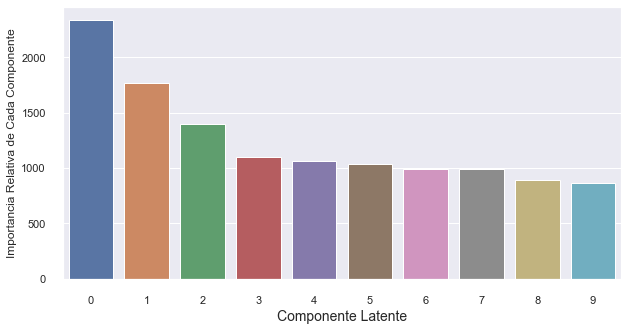

In [46]:
sns.set(rc={'figure.figsize':(10, 5)})
chart = sns.barplot(x=list(range(len(Sigma))), y=Sigma)
chart.set_xlabel('Componente Latente', fontdict={'size': 14})
chart.set_ylabel('Importancia Relativa de Cada Componente', fontdict={'size': 12})
plt.show()

### 6. Obtener la matriz tokens-temas (term-topic) a partir de la matriz 𝑉T de la descomposición SVD.
Despliega sus primeros 5 renglones donde se incluya el nombre de las columnas.

In [50]:
# Obtener la matriz V.T
V_T = SVD.components_.T

term_topic = V_T
term_topic.shape

(100089, 10)

In [58]:
# Obtener los nombres de los términos
term_names = list(tfidfvectorizer.get_feature_names_out())

# Construir dataframe de la matriz term-topic
term_topic_mtx = pd.DataFrame(data=term_topic, index=term_names, 
                              columns=['Concepto_Latente_'+str(i) for i in range(0, num_comp)])

print(term_topic_mtx.shape)

(100089, 10)


In [59]:
# Imprimir los primeros 5 renglones
term_topic_mtx.head(5)

,Concepto_Latente_0,Concepto_Latente_1,Concepto_Latente_2,Concepto_Latente_3,Concepto_Latente_4,Concepto_Latente_5,Concepto_Latente_6,Concepto_Latente_7,Concepto_Latente_8,Concepto_Latente_9
españa,0.092164,-0.007174,-0.002378,-0.054059,0.028084,0.014302,-0.002177,-0.001419,-0.026396,-0.016163
dejado,0.016543,-0.002355,-0.004313,-0.006347,0.001586,-0.000192,-0.002542,0.006867,-0.000281,-0.004753
ser,0.086672,0.004549,0.007282,0.018572,-0.013114,-0.051896,0.021869,-0.022062,-0.041927,-0.007556
católica,0.003085,-0.000337,-0.003085,0.000060,-0.000988,-0.004175,0.001293,-0.004966,-0.002476,-0.000313
decía,0.013632,-0.000755,-0.013170,0.001722,0.001238,-0.005899,0.000345,-0.003411,-0.014538,0.001548
